In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram

In [3]:
erp_mat = loadmat('ERP_data.mat')
erp_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [31]:
trials = erp_mat['EEGData'].shape[2]
dlength = erp_mat['EEGData'].shape[0]
erp_arr = np.zeros([trials, dlength])

for t in range(trials):
    erp_arr[t, :] = erp_mat['EEGData'][:, 0, t]

erp = np.mean(erp_arr, axis=0)

fs = 512 # 1 / np.diff(erp_mat['EEGTime'].ravel())[0]
erp_N = erp.shape[0]
erp_time = erp_mat['EEGTime'].ravel() # np.linspace(0, erp_N / fs, erp_N, endpoint=False)

In [32]:
1 / np.diff(erp_mat['EEGTime'].ravel())[0]

0.512

In [33]:
ssvep_mat = loadmat('SSVEP_data.mat')
ssvep_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [34]:
trials = ssvep_mat['EEGData'].shape[2]
dlength = ssvep_mat['EEGData'].shape[0]
ssvep_arr = np.zeros([trials, dlength])

for t in range(trials):
    ssvep_arr[t, :] = ssvep_mat['EEGData'][:, 0, t]

ssvep = np.mean(ssvep_arr, axis=0)

fs = 256 # 1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]
ssvep_N = ssvep.shape[0]
ssvep_time = ssvep_mat['EEGTime'].ravel() # np.linspace(0, ssvep_N / fs, ssvep_N, endpoint=False)

In [35]:
1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]

0.256

Text(0, 0.5, 'Amplitud')

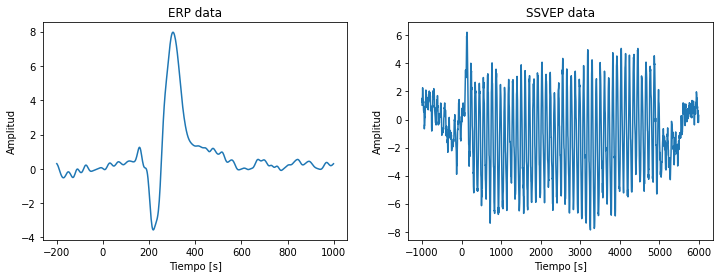

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(erp_time, erp)
ax[1].plot(ssvep_time, ssvep)

ax[0].set_title('ERP data')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud')

ax[1].set_title('SSVEP data')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud')

Text(0, 0.5, 'Amplitud')

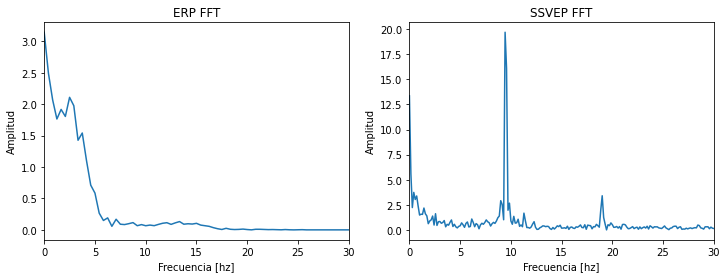

In [39]:
erp_fft = fft(erp)[:erp_N // 2]
erp_ff = fftfreq(erp_N, 1 / fs)[:erp_N // 2]

ssvep_fft = fft(ssvep)[:ssvep_N // 2]
ssvep_ff = fftfreq(ssvep_N, 1 / fs)[:ssvep_N // 2]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(erp_ff, 2 / fs * np.abs(erp_fft))
ax[0].set_xlim([0, 30])

ax[0].set_title('ERP FFT')
ax[0].set_xlabel('Frecuencia [hz]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(ssvep_ff, 2 / fs * np.abs(ssvep_fft))
ax[1].set_xlim([0, 30])

ax[1].set_title('SSVEP FFT')
ax[1].set_xlabel('Frecuencia [hz]')
ax[1].set_ylabel('Amplitud')

## AGREGAR PROMEDIACIÓN ORDENADA Y PONDERADA RESPECTIVAMENTE
- Agregar el método de Welch de la parte 1 para suavizar espectro

In [71]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis) ** 2
    sd = a.std(axis=axis, ddof=ddof) ** 2
    return np.where(sd == 0, 0, m / sd)

def sort_by_snr(data):
    arr = list(data)
    arr.sort(key=lambda x: signaltonoise(x))
    return np.array(arr)

def sort_by_var(data):
    arr = list(data)
    arr.sort(key=lambda x: np.var(x))
    return np.array(arr)

In [72]:
np.mean(erp_arr[0]), erp_arr[0].mean(0), np.std(erp_arr[0]), erp_arr[0].std(axis=0, ddof=0)

(3.9526037786410764, 3.9526037786410764, 3.370585775448713, 3.370585775448713)

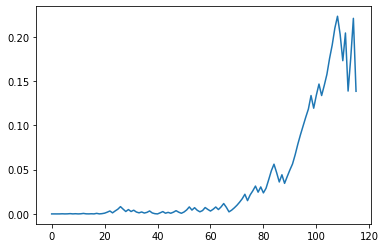

In [74]:
s_erp_arr = sort_by_snr(erp_arr)
s_erp_var = np.var(s_erp_arr, axis=1)

s_erp_snr = np.zeros(s_erp_arr.shape[0])

for i in range(s_erp_arr.shape[0]):
    m_erp = np.mean(s_erp_arr[:i + 1], axis=0)
    s_erp_snr[i] = signaltonoise(m_erp)

fig, ax = plt.subplots()
ax.plot(s_erp_snr)

fig.savefig('erp_msnr.png')
# fig, ax = plt.subplots(2, 2, figsize=(12, 8))
# ax[0][0].plot(ssvep_time, ssvep)
# ax[0][1].plot(ssvep_time, w_ssvep)

# ax[1][0].plot(ssvep_ff, 2 / ssvep_N * np.abs(ssvep_fft))
# ax[1][1].plot(ssvep_ff, 2 / ssvep_N * np.abs(w_ssvep_fft))
# ax[1][0].set_xlim([0, 100])
# ax[1][1].set_xlim([0, 100])

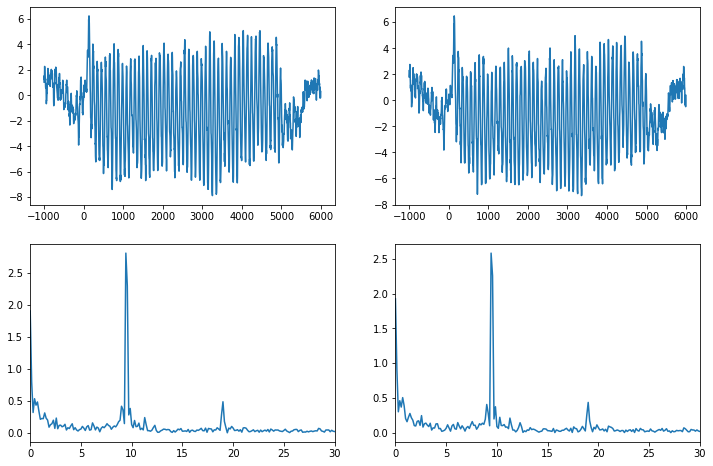

In [50]:
s_ssvep_arr = sort_by_var(ssvep_arr)
s_ssvep_var = np.var(s_ssvep_arr, axis=1)
w = 1 / (s_ssvep_var * np.sum(1 / s_ssvep_var))

w_ssvep = np.average(s_ssvep_arr, axis=0, weights=w)

w_ssvep_fft = fft(w_ssvep)[:ssvep_N // 2]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0][0].plot(ssvep_time, ssvep)
ax[0][1].plot(ssvep_time, w_ssvep)

ax[1][0].plot(ssvep_ff, 2 / ssvep_N * np.abs(ssvep_fft))
ax[1][1].plot(ssvep_ff, 2 / ssvep_N * np.abs(w_ssvep_fft))
ax[1][0].set_xlim([0, 30])
ax[1][1].set_xlim([0, 30])

fig.savefig('ssvep_cmp.png')

In [68]:
ssvep_arr.shape

(45, 1792)